# Mursalin - Assignment 2 (Image Captioning)

# Preliminary and Dataset Loading

In [ ]:
%%capture
#The output display will be suppressed by the previous command
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip Flickr8k_Dataset.zip
!unzip Flickr8k_text.zip

Now we will load some libraries that will be used ahead.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
from IPython.display import Image, display
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model
from keras.utils import np_utils
import random
from keras.preprocessing import image, sequence

Using TensorFlow backend.


Data Loading.
The Flickr_8k.token.txt contains the name of each image followed by “#{digit}” followed by its caption. The
digit refers to the fact that for each image there are multiple captions. 


In [ ]:
images_path = 'Flicker8k_Dataset/' #Folder

captions = open('Flickr8k.token.txt', 'r').read().split("\n")[:-1]
x_train = open('Flickr_8k.trainImages.txt', 'r').read().split("\n")[:-1]
x_val = open('Flickr_8k.devImages.txt', 'r').read().split("\n")[:-1]
x_test = open('Flickr_8k.testImages.txt', 'r').read().split("\n")[:-1]

Resolving the captions and images

Pandas is a library in Python for data manipulation and analysis. We will use it for file creation and data manipulation.
Generate Train/Test Dataset files for loading in Pandas. 
We will make a Pandas DataFrame for ease when making the model, hence we will create a CSV File from the Datasets.

In [ ]:
%%capture
tokens = {}

for i in range(len(captions)-1):
    temp = captions[i].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append("<START> "+ temp[1][2:] + " <END>")
    else:
        tokens[temp[0]] = ["<START> "+ temp[1][2:] + " <END>"]

train_dataset = open('flickr_8k_train_dataset.txt','wb')
val_dataset = open('flickr_8k_val_dataset.txt','wb')
test_dataset = open('  flickr_8k_test_dataset.txt','wb')

train_dataset.write(b"image_id\tcaptions\n")
val_dataset.write(b"image_id\tcaptions\n")
test_dataset.write(b"image_id\tcaptions\n")

Adding the data to the above created files with Image IDs and captions for each image.

In [ ]:
for img in x_train:
    if img == '':
        continue
    for capt in tokens[img]:
        train_dataset.write((img+"\t"+capt+"\n").encode())
        train_dataset.flush()
train_dataset.close()

for img in x_test:
    if img == '':
        continue
    for capt in tokens[img]:
        test_dataset.write((img+"\t"+capt+"\n").encode())
        test_dataset.flush()
test_dataset.close()

for img in x_val:
    if img == '':
        continue
    for capt in tokens[img]:
        val_dataset.write((img+"\t"+capt+"\n").encode())
        val_dataset.flush()
val_dataset.close()

# Pre-processing Steps

Now, pre-trained ResNet 50 is loaded with last layer removed to get feature vectors. Image Preprocessing is also done.

In [ ]:
%%capture
model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    return np.expand_dims(image.img_to_array(im), axis=0)

train_data = {}
for i, val in enumerate(x_train):
    train_data[val] = model.predict(preprocessing(images_path + val)).reshape(2048)

with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_data, pickle_f )  

Image is now being loaded along with its corresponding caption into a dataframe. Then values from dataframe is being stored in ds. Then we collect all the words used in captions and vectorize them to be used for training.

In [ ]:
pd_dataset_train = pd.read_csv("flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset_train.values

sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])
    
words = [i.split() for i in sentences]
unique = []
for i in words:
    unique.extend(i)
unique = list(set(unique))

vocab_size = len(unique)

word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

word_2_indices['UNK'] = 8253
indices_2_word[8253] = 'UNK'

vocab_size = len(word_2_indices.keys())
 #Max length setup
max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

# print(max_len)

In [ ]:
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
    
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)


In [ ]:
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])
num_of_images = 3000

for ix in range(num_of_images):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])

np.save("captions.npy", captions)
np.save("next_words.npy", next_words)


In [ ]:
%%capture
globals().keys()

with open('train_encoded_images.p', 'rb') as f:
    encoded_images = pickle.load(f, encoding="bytes")

imgs = []

for ix in range(ds.shape[0]):
    if ds[ix, 0] in encoded_images.keys():
        imgs.append(list(encoded_images[ds[ix, 0]]))
imgs = np.asarray(imgs)

In [ ]:
images = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)

np.save("images.npy", images)


image_names = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])
        
image_names = np.asarray(image_names)

np.save("image_names.npy", image_names)

# Model Building

In [ ]:
captions = np.load("captions.npy")
next_words = np.load("next_words.npy")
images = np.load("images.npy")
imag = np.load("image_names.npy")

embedding_size = 128

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 40, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


In [ ]:
language_model = Sequential()
language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 128)           1056512   
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 256)           394240    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 128)           32896     
Total params: 1,483,648
Trainable params: 1,483,648
Non-trainable params: 0
_________________________________________________________________


In [ ]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
x = Dropout(0.3)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  (None, 40)           0                                            
__________________________________________________________________________________________________
dense_1_input (InputLayer)      (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 128)      1056512     embedding_1_input[0][0]          
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          262272      dense_1_input[0][0]              
____________________________________________________________________________________________

Due to the contraints of computation power and RAM availability, splitting of training data is done for validation instead of using the validation dataset.

In [ ]:
hist = model.fit([images, captions], next_words, batch_size=256, validation_split=0.1, epochs=90)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 34344 samples, validate on 3817 samples
Epoch 1/90
34344/34344 [==============================] - 47s 1ms/step - loss: 6.8274 - accuracy: 0.0724 - val_loss: 5.6092 - val_accuracy: 0.0755
Epoch 2/90
34344/34344 [==============================] - 45s 1ms/step - loss: 6.5691 - accuracy: 0.0763 - val_loss: 5.4657 - val_accuracy: 0.0838
Epoch 3/90
34344/34344 [==============================] - 45s 1ms/step - loss: 6.5279 - accuracy: 0.0767 - val_loss: 5.4961 - val_accuracy: 0.0739
Epoch 4/90
34344/34344 [==============================] - 44s 1ms/step - loss: 6.5279 - accuracy: 0.0742 - val_loss: 5.5274 - val_accuracy: 0.0770
Epoch 5/90
34344/34344 [==============================] - 44s 1ms/step - loss: 6.4274 - accuracy: 0.1044 - val_loss: 5.2093 - val_accuracy: 0.1483
Epoch 6/90
34344/34344 [==============================] - 44s 1ms/step - loss: 6.3039 - accuracy: 0.1217 - val_loss: 5.2643 - val_accuracy: 0.1470
Epoch 7/90
34344/34344 [==============================] - 44s 1ms/ste

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%%capture
#In order to save weights
model.save_weights("/content/drive/My Drive/CV_Assignment2/model_weights_Ass2.h5")
!cp "captions.npy" -r "/content/drive/My Drive/CV_Assignment2/captions.npy"
!cp "next_words.npy" -r "/content/drive/My Drive/CV_Assignment2/next_words.npy"
!cp "image_names.npy" -r "/content/drive/My Drive/CV_Assignment2/image_names.npy"
!cp "captions.npy" -r "/content/drive/My Drive/CV_Assignment2/images.npy"
!ls *.npy

#Prediction

Making useful functions which will be used ahead and also loading RESNET Model.

In [ ]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    return pred

def predict_captions(image):
    start_word = ["<START>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<END>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

# Testing Results

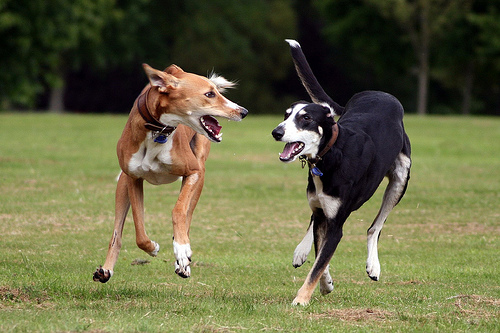

Generated Caption:
A brown dogs running through the grass .
Actual Caption:
<START> A large brown dog and a large black and white dog running together <END>
<START> Two dogs are running in a grassy field . <END>
<START> Two dogs , one brown and white and one black and white , run on a field . <END>
<START> Two dogs run and bark outdoors , one white and brown , one white and black . <END>
<START> Two lean dogs , one brown and white and one black and white , run together . <END>


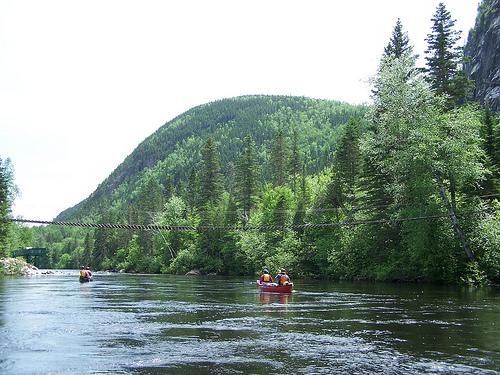

Generated Caption:
A group of people is walking on a trail path .
Actual Caption:
<START> A kayak on the river is passing by a wire bridge that joins both banks . <END>
<START> Some people ride their kayaks down the river . <END>
<START> two conoes float down the river . <END>
<START> Two groups are canoeing on a river overlooking a mountain . <END>
<START> Two people rafting down a river , a footbridge in the background . <END>


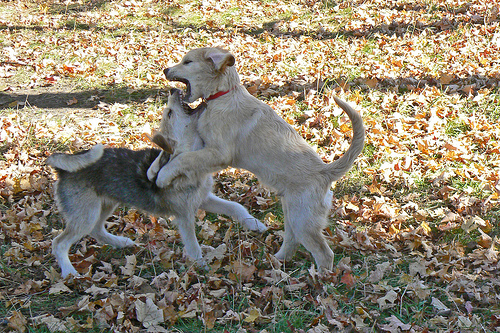

Generated Caption:
Two dogs play together and three dog are chasing while chasing while chasing while chasing by mouth .
Actual Caption:
<START> Two dogs jumping on one another on a grassy area covered in leaves . <END>
<START> Two dogs play with each other in the leaves . <END>
<START> Two puppies are playing in the leaves . <END>
<START> two puppies playing with each other surrounded by a bunch of leaves <END>
<START> Two small dogs , light and dark colored , fighting on leaves . <END>


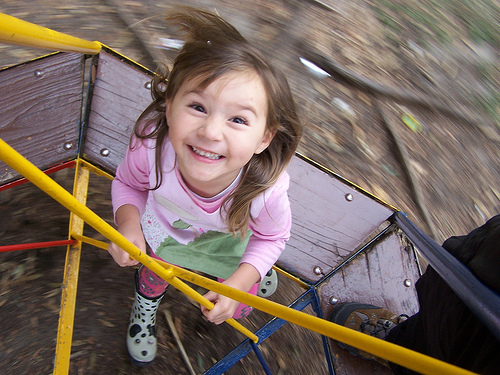

Generated Caption:
A man on a trampoline .
Actual Caption:
<START> A little girl gets her picture taken while on the merry-go-round . <END>
<START> A little girl in pink clothes holding yellow rods . <END>
<START> A little girl on a piece of playground equipment <END>
<START> A little girl sitting on a playground ride . <END>
<START> A young girl looks up as she rides on a merry-go-round . <END>


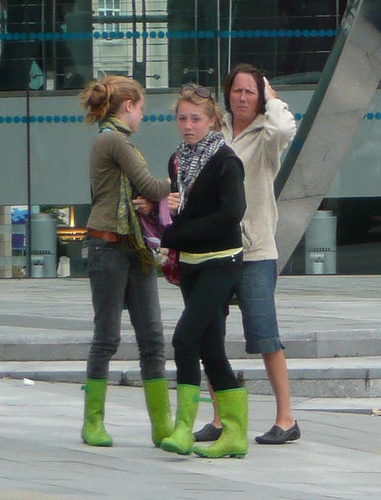

Generated Caption:
A bald men walk past a martial arts fight in a ball .
Actual Caption:
<START> Three women standing on a city street . <END>
<START> Three women walk down the street . <END>
<START> Two girls and a woman walking on the sidewalk <END>
<START> Two girls in bright green boots and a woman are together . <END>
<START> Two young ladies in green boots are walking through an urban area while an older lady wearing black shoes follows them . <END>


<Figure size 720x3600 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import random
plt.figure(figsize=(10,50))
for i in range (5):
  ind = random.randint(0,len(x_test))
  img = "Flicker8k_Dataset/"+ x_test[ind]
  test_img = get_encoding(resnet, img)
  Argmax_Search = predict_captions(test_img)
  z = image.load_img(img)
  # plt.subplot(10,1,i+1)
  # plt.imshow(z)
  display(z)
  print("Generated Caption:\n" + Argmax_Search)
  print ("Actual Caption:")
  for j in tokens[x_test[ind]]:
    print(j)

Text(0.5, 1.0, 'Training Accuracy')

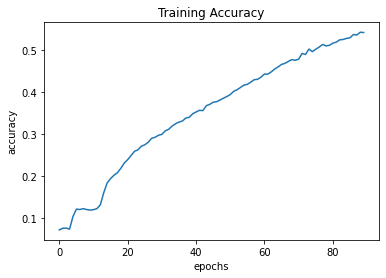

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training Accuracy')